## Importing necessary libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import math
np.random.seed(130298) 

In [2]:
from imblearn.over_sampling import SMOTE 
from sklearn.pipeline import Pipeline
from imblearn.pipeline import Pipeline as Pipeline_imb
from sklearn.compose import ColumnTransformer, make_column_transformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, FunctionTransformer 
from sklearn.impute import KNNImputer

In [3]:
from sklearn.feature_selection import SelectFromModel, SelectKBest, chi2, RFECV, SelectFpr, SelectFdr
from sklearn import svm
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression, Perceptron
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import auc, f1_score, recall_score, precision_score, roc_curve, confusion_matrix

In [4]:
from sklearn.model_selection import RandomizedSearchCV, RepeatedStratifiedKFold
from sklearn.model_selection import cross_validate, cross_val_score, GridSearchCV

In [6]:
def compute_metrics(Y, final_pred):
    fpr, tpr, _ = roc_curve(Y,final_pred)
    AUC = auc(fpr, tpr)
    f1 = f1_score(Y,final_pred)
    print(f'AUC: {np.round(AUC,3)}, F1: {np.round(f1,3)}')
    return [AUC, f1]

## Datasets definition

In [7]:
outcome_name = 're.admission.within.6.months'

# take the training set
X_train = pd.read_csv('train_data_drugs.csv')
X_train.set_index('inpatient.number', inplace = True)

# separate the outcome
Y_train = X_train[outcome_name].copy()
X_train.drop(columns = outcome_name, inplace = True)

# take the test set
X_test = pd.read_csv('test_data_drugs.csv')
X_test.set_index('inpatient.number', inplace = True)

# separate the outcome
Y_test = X_test[outcome_name].copy()
X_test.drop(columns = outcome_name, inplace = True)
print(f'Size of training set: {X_train.shape} and of test set: {X_test.shape}')

Size of training set: (1567, 81) and of test set: (397, 81)


We decide to transform some variables (as identified in the file 2_Data_cleaning) with a skewed distribution using the logarithm: a distribution with less heavy tails can help the models to learn better.

In [8]:
# Log transformations
var_to_log = ['creatinine.enzymatic.method', 'urea', 'glomerular.filtration.rate', 
              'cystatin', 'lymphocyte.count', 'neutrophil.count',
              'activated.partial.thromboplastin.time', 'prothrombin.time.ratio',
              'glutamyltranspeptidase','indirect.bilirubin','alkaline.phosphatase',
              'globulin','direct.bilirubin', 'low.density.lipoprotein.cholesterol', 
              'triglyceride']
X_train[var_to_log] = np.log(X_train[var_to_log])
X_test[var_to_log] = np.log(X_test[var_to_log])

In [9]:
# take the lists of variables by type
cat_columns = ['DestinationDischarge','admission.ward','admission.way','discharge.department',
                       'type.of.heart.failure', 'NYHA.cardiac.function.classification', 'Killip.grade',
                       'consciousness', 'ageCat']

ordinal_columns = ['CCI.score', 'eye.opening','verbal.response', 'movement', 'GCS']

binary_columns = ['gender', 'diabetes', 'moderate.to.severe.chronic.kidney.disease',
                  'diuretics', 'hypertension', 'heart_failure', 'angina_etal', 'cholesterol']

not_continuous = cat_columns.copy()
not_continuous.extend(binary_columns)
not_continuous.extend(ordinal_columns)

In [10]:
cont_columns = [col_name for col_name in X_train.columns if col_name not in not_continuous]

In [11]:
# THIS IS A CATEGORICAL FEATURE WHICH WILL BE ONE-HOT-ENCODED BUT HAS SOME NaN. 
# To avoid problems, we impute it before with the mode

X_train['DestinationDischarge'].fillna(X_train['DestinationDischarge'].mode().values[0], inplace=True)
X_test['DestinationDischarge'].fillna(X_train['DestinationDischarge'].mode().values[0], inplace=True)

## Pipeline definition

We set up the processing of our data through a Pipeline: first we standardized the continuous variables, and we encoded categorical variables using One Hot Encoding. Then, since in the dataset there are some missing values, we implement a KNNImputer which imputes each one of them using the average of the 5 nearest neighbors.

In [12]:
oneHot_encoder = OneHotEncoder(handle_unknown='ignore')

preprocessing_pipeline = ColumnTransformer([
    ("num", StandardScaler(), cont_columns),
    ("cat", oneHot_encoder, cat_columns)],  
    remainder = 'passthrough',               
    verbose_feature_names_out = False)       

full_pipeline = Pipeline([
    ('preprocessing', preprocessing_pipeline),
    ('imputer', KNNImputer())
])

# Models

We evaluate all methods by cross-validating the performance on the training set. The same CV scheme is use for all models, and consequently results are comparable.
We choose the $F1$ score since it is an average between Recall and Precision, taking into account both mistakes on the positive and on the negative class.

For the algorithms which also needed tuning, we implement a nested cross-validation strategy: it allows to find parameters trough a Grid-Search for every cross validation fold and at the same time to get an estimate of the chosen score. This ensures the significance of the estimates and avoids optimistic measures of performance, which would then be overturned by testing the final model on the hold-out set.

# Logistic Regression 

Since collinearity among features might still be present, we considered an Elastic-Net penalty, which takes into account both the L2 norm and the L1 norm, which induces sparsity.

## Elastic Net

We used the saga solver, since the ElasticNet regularization is only supported by that and we set the balance mode which uses the values of Y_train to automatically adjust weights inversely proportional to class frequencies in the input data. We increased the number of iterations to guarantee the convergence.

In [13]:
elasticnet_model = LogisticRegression(penalty = 'elasticnet', solver = 'saga', 
                                 class_weight = 'balanced', max_iter = 5000, random_state=42)

#Pipeline: preprocessing + Logistic regression model with elasticnet penalization
LR12_pipeline = Pipeline([('preprocessing', full_pipeline),
                            ('logistic', elasticnet_model)])

### Tuning hyperparameters:

- C: represent the inverse of regularization strength, smaller values specify stronger regularization
- l1_ratio: is the Elastic-Net mixing parameter, l1_ratio=1 is equivalent to using penalty='l1' 


In [14]:
#Hyperparameters grid
param_grid={"logistic__C": [0.1,0.01,1.0],
            "logistic__l1_ratio":[0.25,0.5,0.75]}

cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=42)

GS_elasticnet = GridSearchCV(LR12_pipeline, param_grid, cv=cv, scoring="f1", n_jobs=-1)

In [15]:
scores = cross_validate(GS_elasticnet, X_train, Y_train, scoring = 'f1',
                           return_train_score = True, n_jobs=-1)
print('---------------------------------')
print(str('Logistic regression with Elasticnet penalty'))
print('---------------------------------')
error_train = scores['train_score']
error_test = scores['test_score']
print(f'train_score: mean = {np.round(error_train.mean(),3)}, std = {np.round(error_train.std(),3)}')
print(f'validation_score: mean = {np.round(error_test.mean(),3)}, std = {np.round(error_test.std(),3)}')

---------------------------------
Logistic regression with Elasticnet penalty
---------------------------------
train_score: mean = 0.612, std = 0.012
validation_score: mean = 0.551, std = 0.026


# Support vector machine

Then, we tried to implement a support vector machine to deal with the high-dimensionality of the data, thanks to the kernel trick. For this reason, no prior feature selection is implemented in this case. We used a Radial Basis Function kernel, which is the
most seen in literature

In [171]:
#Pipeline: preprocessing + SVM
SVM_pipeline = Pipeline([
    ('preprocessing', full_pipeline),
    ('SVM', svm.SVC(class_weight = 'balanced',random_state=42))
])

### Tuning hyperparameters:
- C: represent the inverse of the regularization strength
- gamma: is the kernel coefficient for ‘rbf’

In [172]:
#Hyperparameters grid
param_grid = {'SVM__C': [0.5,1,2,4,6,8,10], 
              'SVM__gamma': [1, 0.1, 0.01, 0.001, 0.0001,'auto','scale']}

cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=1, random_state=42)

RS_SVM = RandomizedSearchCV(SVM_pipeline, param_grid, cv=cv, scoring='f1',
                         random_state=42, verbose = 1, n_jobs=-1)

In [173]:
score = cross_validate(estimator=RS_SVM, X=X_train, y=Y_train, cv=cv,scoring="f1",
                               n_jobs = -1,return_train_score = True,error_score="raise")

print('------------------------------------------------------------------')
print(str('SVM'))
print('------------------------------------------------------------------')
error_train = score['train_score']
error_test = score['test_score']
print(f'train_score: mean = {np.round(error_train.mean(),3)}, std = {np.round(error_train.std(),3)}')
print(f'validation_score: mean = {np.round(error_test.mean(),3)}, std = {np.round(error_test.std(),3)}')

------------------------------------------------------------------
SVM
------------------------------------------------------------------
train_score: mean = 0.686, std = 0.069
validation_score: mean = 0.527, std = 0.036


# Decision Tree Classifier

We tried to implement a Decision Tree classifier, a non-parametric supervised learning methods which is simple to understand and to interpret.

In [174]:
#Pipeline: preprocessing + DecisionTree
DT_pipeline = Pipeline([
    ('preprocessing', full_pipeline),
    ('DT', DecisionTreeClassifier(random_state = 42))
])

## 1. Fit a simple DT

In [175]:
clfs = []
clfs.append(DecisionTreeClassifier(random_state = 42))
clfs.append(DecisionTreeClassifier(class_weight = 'balanced', random_state = 42))
clfs.append(DecisionTreeClassifier(max_depth=10, random_state = 42))
clfs.append(DecisionTreeClassifier(class_weight = 'balanced', max_depth=5, random_state = 42))

for classifier in clfs:
    DT_pipeline.set_params(DT = classifier)
    scores = cross_validate(DT_pipeline, X_train, Y_train, scoring = 'f1',
                           return_train_score = True)
    print('---------------------------------')
    print(str(classifier))
    print('---------------------------------')
    error_train = scores['train_score']
    error_test = scores['test_score']
    print(f'train_score: mean = {np.round(error_train.mean(),3)}, std = {np.round(error_train.std(),3)}')
    print(f'validation_score: mean = {np.round(error_test.mean(),3)}, std = {np.round(error_test.std(),3)}')

---------------------------------
DecisionTreeClassifier(random_state=1)
---------------------------------
train_score: mean = 1.0, std = 0.0
validation_score: mean = 0.419, std = 0.042
---------------------------------
DecisionTreeClassifier(class_weight='balanced', random_state=1)
---------------------------------
train_score: mean = 1.0, std = 0.0
validation_score: mean = 0.448, std = 0.04
---------------------------------
DecisionTreeClassifier(max_depth=10, random_state=1)
---------------------------------
train_score: mean = 0.871, std = 0.029
validation_score: mean = 0.388, std = 0.037
---------------------------------
DecisionTreeClassifier(class_weight='balanced', max_depth=5, random_state=1)
---------------------------------
train_score: mean = 0.651, std = 0.02
validation_score: mean = 0.508, std = 0.021


From this models we can make some considerations:
- a plain DT strongly overfits the training set
- using balanced weights, increases performance on test set, but still overfits training
- setting the maximum depth of the tree decreases performance on test set, but also on training set (reduces overfitting)
- setting both balanced weights and maximum tree depth allows for better performance on testing, while keeping a contained performance on training.

With these observations in mind, we try to set some hyperparameters trough a grid search.

## 2. Try a Grid Search to select some parameters

### Tuning hyperparameters:

- criterion: it is the function to measure the quality of a split, “gini” is the supported criteria for the Gini impurity (it splits the node such that it gives the least amount of impurity) and “entropy” for the information gain (it splits the node such that it gives the most amount of information gain)
- min_samples_split: the minimum number of samples required to split an internal node
- max_depth: maximum depth of the tree

We notice that min_samples_split is tied to max_depth and the model selects one over the other depending on which gives the maximum depth for the tree.


In [176]:
param_grid = {'DT__criterion': ["gini", "entropy"], 
              'DT__min_samples_split': np.linspace(0.4,1,9),
              'DT__max_depth': np.arange(3,15)}

cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=42)

In [177]:
DT_pipeline.set_params(DT = DecisionTreeClassifier(class_weight='balanced', random_state = 1))

DT_RS = RandomizedSearchCV(DT_pipeline, param_grid, cv=cv, scoring='f1',n_iter=50,
                         random_state=42, verbose = 1, n_jobs=-1)

In [178]:
scores = cross_validate(estimator=DT_RS, X=X_train, y=Y_train, cv=cv,scoring="f1",
                               n_jobs = -1,return_train_score = True)

print('------------------------------------------------------------------')
print(str("DecisionTree"))
print('------------------------------------------------------------------')
error_train = scores['train_score']
error_test = scores['test_score']
print(f'train_score: mean = {np.round(error_train.mean(),3)}, std = {np.round(error_train.std(),3)}')
print(f'validation_score: mean = {np.round(error_test.mean(),3)}, std = {np.round(error_test.std(),3)}')

------------------------------------------------------------------
DecisionTree
------------------------------------------------------------------
train_score: mean = 0.553, std = 0.031
validation_score: mean = 0.524, std = 0.052


# Random Forest
Let's try to reduce the overfitting problem, by using ensamble methods which try to reduce the variance of the estiamtes. First, we look at the cross validation score of a vanilla RF.

In [35]:
#Pipeline: preprocessing + Random Forest
RF_pipeline = Pipeline([
    ('preprocessing', full_pipeline),
    ('clf', RandomForestClassifier(class_weight = 'balanced', random_state = 42))
])

### Tuning hyperparameters:
- max_depth: maximum depth of the tree
- min_saples_leaf: minimum number of data points allowed in a leaf node
- min_samples_split: minimum number of samples required to split an internal node
- max_leaf_nodes: it caps the number of leaf nodes and allows the branches of a tree to have varying depths.
- min_impurity_decrease: it is used to supervise the threshold for splitting nodes: split will take place if it reduces the Gini Impurity. Useful when there is a big quantity of features in the dataset.
- n_estimators: number of decision trees

In [48]:
#Hyperparameters grid
param_grid = {'clf__max_depth': np.arange(5,10), 
              'clf__min_samples_leaf': np.linspace(10,20,2).astype(int), 
              'clf__min_samples_split': np.linspace(0.4,1,3), 
              'clf__min_impurity_decrease': np.linspace(0,0.4,4), 
              'clf__max_leaf_nodes': np.linspace(10,20,2).astype(int),
              'clf__n_estimators': [100,150]
             }
cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=42)

In [49]:
RF_RS = GridSearchCV(RF_pipeline, param_grid, cv=cv, scoring='f1',verbose = 1, n_jobs=-1)

score = cross_validate(estimator=RF_RS, X=X_train, y=Y_train, cv=cv,scoring="f1",
                               n_jobs = -1,return_train_score = True,error_score="raise")

In [50]:
error_train = score['train_score']
error_test = score['test_score']
print(f'train_score: mean = {np.round(error_train.mean(),3)}, std = {np.round(error_train.std(),3)}')
print(f'validation_score: mean = {np.round(error_test.mean(),3)}, std = {np.round(error_test.std(),3)}')

train_score: mean = 0.561, std = 0.007
validation_score: mean = 0.505, std = 0.03


## Selecting some features before fitting the forest

We test the random forest using different features selection methods:

- SelectKBest is an univariate features selection method, which works by selecting the best features based on univariate statistical tests. In particular, it tests each feature against the outcome using Anova, and removing all but the k features having smallest p-value.

- SelectFromModel finds the best features based on the coefficients obtained fitting the given estimator (in our case, the Elastic-net Logistic Regression which puts the weight of some features automatically to 0).

- Recursive Feature Elimination uses the given estimator (Perceptron and Decision Tree in our case) to compute coefficients of the features, and recursively eliminates the one having smaller weight. The optimal number of features is selected in a CV loop.

In [55]:
#Pipeline: preprocessing + feature selection method + Random Forest
RF_pipeline = Pipeline([
    ('preprocessing', full_pipeline),
    ('feature_selection', SelectFromModel(elasticnet_model)),
    ('clf', RandomForestClassifier(class_weight = 'balanced', max_depth = 5, random_state = 42))
])

In [56]:
#Hyperparameters grid
param_grid = {'clf__max_depth': np.arange(3,10), 
              'clf__min_samples_leaf': np.linspace(1,20,5).astype(int), 
              'clf__min_samples_split': np.linspace(0.4,1,5), 
              'clf__min_impurity_decrease': np.linspace(0,0.4,4), 
              'clf__max_leaf_nodes': np.linspace(10,20,3).astype(int),
              'clf__n_estimators': [100,150]
             }

cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=42)

In [58]:
#We cross-validate and compared the Random Forest classifier with different 
#features selection methods
select = []
select.append(SelectKBest(k=60))
select.append(SelectFromModel(elasticnet_model))
select.append(RFECV(estimator=Perceptron(random_state=42, class_weight='balanced')))
select.append(RFECV(estimator=DecisionTreeClassifier(class_weight = 'balanced', max_depth=5, random_state=42)))

for method in select:
    RF_pipeline.set_params(feature_selection = method)
    RF_RS = RandomizedSearchCV(RF_pipeline, param_grid, cv=cv, scoring='f1',n_iter=30,
                         random_state=1, verbose = 1, n_jobs=-1)
    
    scores = cross_validate(estimator=RF_RS, X=X_train, y=Y_train, cv=cv,scoring="f1",
                               n_jobs = -1,return_train_score = True,error_score="raise")

    print('------------------------------------------------------------------')
    print(str(method))
    print('------------------------------------------------------------------')
    error_train = scores['train_score']
    error_test = scores['test_score']
    print(f'train_score: mean = {np.round(error_train.mean(),3)}, std = {np.round(error_train.std(),3)}')
    print(f'validation_score: mean = {np.round(error_test.mean(),3)}, std = {np.round(error_test.std(),3)}')

------------------------------------------------------------------
SelectKBest(k=60)
------------------------------------------------------------------
train_score: mean = 0.563, std = 0.008
validation_score: mean = 0.501, std = 0.034
------------------------------------------------------------------
SelectFromModel(estimator=LogisticRegression(class_weight='balanced',
                                             l1_ratio=0.5, max_iter=5000,
                                             penalty='elasticnet',
                                             random_state=42, solver='saga'))
------------------------------------------------------------------
train_score: mean = 0.566, std = 0.012
validation_score: mean = 0.51, std = 0.029
------------------------------------------------------------------
RFECV(estimator=Perceptron(class_weight='balanced', random_state=42))
------------------------------------------------------------------
train_score: mean = 0.567, std = 0.015
validation_score:

# Extreme Gradient Boosting

We tried also to implement an ensable method and we focused on Extreme Gradient Boost because is a more regularized form of Gradient Boosting which uses advanced regularization techniques to improve the model generalization capabilities.

In [62]:
#Pipeline: preprocessing + XGboost
GB_pipeline = Pipeline([
    ('preprocessing', full_pipeline),
    ('clf',XGBClassifier(objective= 'binary:logistic',booster='gbtree',nthread=4,seed=42))
])

### Tuning hyperparameters:

- gamma: minimum loss reduction required to make a further partition on a leaf node of the tree. The larger gamma is, the more conservative the algorithm will be.
- colsample_bytree: subsample ratio of features when constructing each tree
- learning_rate: step size shrinkage used in the update to prevent overfitting
- max_depth: maximum depth of the tree
- min_child_weight: minimum sum of instance weights needed in a child for a further partition
- n_estimators: number of decision trees
- scale_pos_weight: it controls the balance of positive and negative weights. Useful for unbalanced classes


In [63]:
scale_pos = ( Y_train.shape[0]-Y_train.sum() ) / Y_train.sum()

#Hyperparameters grid
param_grid = {'clf__gamma': [1,3,5],
              'clf__colsample_bytree': [0.6,0.65,0.75],
              'clf__learning_rate': [0.03,0.05,0.08],
              'clf__max_depth': [2,3,4],
              'clf__min_child_weight': [1,5,10],
              'clf__n_estimators': [100,150,200],
              'clf__scale_pos_weight': [scale_pos]}

cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=42)

RS_GB = RandomizedSearchCV(GB_pipeline, param_grid, cv=cv, scoring='f1',n_iter=30,
                         random_state=1, verbose = 1, n_jobs=-1)

In [64]:
scores = cross_validate(estimator=RS_GB, X=X_train, y=Y_train, cv=cv,scoring="f1",
                        n_jobs = -1,return_train_score = True)
print('------------------------------------------------------------------')
print(str("XGBoost"))
print('------------------------------------------------------------------')
error_train = scores['train_score']
error_test = scores['test_score']
print(f'train_score: mean = {np.round(error_train.mean(),3)}, std = {np.round(error_train.std(),3)}')
print(f'validation_score: mean = {np.round(error_test.mean(),3)}, std = {np.round(error_test.std(),3)}')

------------------------------------------------------------------
XGBoost
------------------------------------------------------------------
train_score: mean = 0.728, std = 0.044
validation_score: mean = 0.511, std = 0.034


# ElasticNet + SMOTE

At the end a trial was also done using SMOTE: this method over-samples the minority class by adding some synthetic points with similar characteristics to a minority class point.
Since the over-sampling should only be done during the training phase, it should be added to a Pipeline able to fit the transformation over the training set but not act on the test set in the transform step. For this, we introduced a new Pipeline from the imblearn library. Then, we repeated the same process of logistic regression.

In [179]:
elasticnet_model = LogisticRegression(penalty = 'elasticnet', solver = 'saga', 
                                 l1_ratio = 0.5, max_iter = 5000, random_state=42)

#Imblearn pipeline: Smote + logistic regression
LR12_pipeline_imb = Pipeline_imb([
        ('smote', SMOTE(random_state=42)),
        ('logistic', elasticnet_model)])

#Pipeline: preprocessing + Imblearn pipeline:
LR12_smote_pipeline = Pipeline([('preprocessing', full_pipeline),
                                ('pip_smote', LR12_pipeline_imb)])

In [180]:
scores = cross_validate(LR12_smote_pipeline, X_train, Y_train, scoring = 'f1',
                           return_train_score = True)
print('---------------------------------')
print(str('Logistic regression with Elasticnet penalty'))
print('---------------------------------')
error_train = scores['train_score']
error_test = scores['test_score']
print(f'train_score: mean = {np.round(error_train.mean(),3)}, std = {np.round(error_train.std(),3)}')
print(f'validation_score: mean = {np.round(error_test.mean(),3)}, std = {np.round(error_test.std(),3)}')

---------------------------------
Logistic regression with Elasticnet penalty
---------------------------------
train_score: mean = 0.609, std = 0.01
validation_score: mean = 0.545, std = 0.031


This procedure does not improve the performance of the model, rather it slightly deteriorates it. This may be due to the fact that ElasticNet class_weight = 'balanced' works already well with unbalanced dataset.

# Best Model: Logistic Regression with ElasticNet

Looking at these results, the model having the best performance in terms of $F1$ is the Logistic Regression with Elastic-Net penalty. We fit this model on all training and test set to get an estimate of its predictive capabilities.

### Performance on test data

In [17]:
GS_elasticnet.fit(X_train,Y_train)
print('Training performances:')
m1 = compute_metrics(Y_train, GS_elasticnet.predict(X_train))
print('Test performances:')
m2 = compute_metrics(Y_test, GS_elasticnet.predict(X_test))

Training performances:
AUC: 0.661, F1: 0.602
Test performances:
AUC: 0.607, F1: 0.539


The AUC on the test set is not very high but this is already a little improvement w.r.t. the results of the literature. 

In [18]:
final_model = GS_elasticnet.best_estimator_.named_steps['logistic']
feature_names = list(GS_elasticnet.best_estimator_.named_steps['preprocessing'][:-1].get_feature_names_out(input_features=X_train.columns))

### Features importance 

To have an idea of the drivers in the prediction of the readmission within six months, we show the 15 highest coefficients in the Logistic Regression model. 

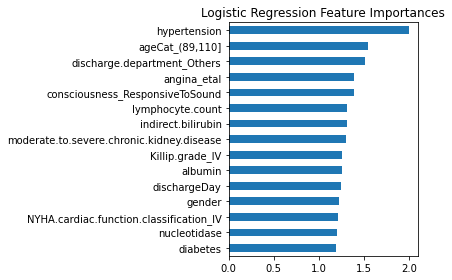

In [20]:
feature_importances = pow(math.e,final_model.coef_[0])

importances = pd.Series(
    feature_importances[:106], index=feature_names[:106]
).sort_values(ascending=True)

ax = importances[91:].plot.barh()
ax.set_title("Logistic Regression Feature Importances")
ax.figure.tight_layout()